In [1]:
import glob

import cupy as cp
import numpy as np
from PIL import Image, ImageFilter, ImageEnhance

import dezero
from dezero import DataLoader, optimizers, Parameter, test_mode
from dezero import optimizers,test_mode, cuda
import dezero.layers as L
import dezero.functions as F
from dezero.models import Model
from dezero.core import Function, Variable

import matplotlib.pyplot as plt

this notebook used "Nails segmentation(CC0)".　<br>
https://www.kaggle.com/datasets/vpapenko/nails-segmentation

### Functions for data augmentation

In [2]:
def random_horizontal_flip(img_1, img_2, p=0.5):
    """
    random horizontal flip for semantic segmantation
    
    Parameters
    ----------
    img_1 : ndarray
        2dim or 3dim(channels last)
    img_2 : ndarray
        2dim or 3dim(channels last)
    p : float
        Probability of horizontal flip.
        from 0 to 1.
    """
    if p < np.random.random():
        return img_1, img_2  #return original image
    
    return img_1[:, ::-1], img_2[:, ::-1]


def random_vertical_flip(img_1, img_2, p=0.5):
    """
    random vertical flip for semantic segmantation
    
    Parameters
    ----------
    img_1 : ndarray
        2dim or 3dim(channels last)
    img_2 : ndarray
        2dim or 3dim(channels last)
    p : float
        Probability of horizontal flip. 
        from 0 to 1.
    """
    if p < np.random.random():
        return img_1, img_2  #return original image
    
    return img_1[::-1, :], img_2[::-1, :]


def random_gaussian_blur(img, p=0.5):
    """
    randamly apply gaussian blur to the image for data augmentation
    
    Parameters
    ----------
    img : PIL
    p : float
        Probability of changing gaussian blur.
        from 0 to 1
    """
    if p < np.random.random():
        return img   #return original image
    
    img = img.filter(
        ImageFilter.GaussianBlur(np.random.random()*0.5 + 0.2))
    return img


def random_brightness(img, p=0.5):
    """
    randamly change image brightness for data augmentation
    
    Parameters
    ----------
    img : PIL
    p : float
        Probability of changing image brightness.
        from 0 to 1
    """
    if p < np.random.random(): 
        return img   #return original image
    
    brightness = np.random.random() + 0.5 
    return img.point(lambda x: x * brightness)


def random_enhance(img, p=0.5):
    """
    randamly change image saturation for data augmentation
    
    Parameters
    ----------
    img : PIL
    p : float
        Probability of image enhance.
        from 0 to 1
    """
    if p < np.random.random():
        return img   #return original image
    
    enhancer = ImageEnhance.Color(img)
    return enhancer.enhance(np.random.random())


def random_contrast(img, p=0.5):
    """
    randamly change image contrast for data augmentation
    
    Parameters
    ----------
    img : PIL
    p : float
        Probability of changing image contrast.
        from 0 to 1.
    """
    if p < np.random.random():
        return img   #return original image
    
    enhancer = ImageEnhance.Contrast(img)
    return enhancer.enhance(0.5 + 0.5 * np.random.random())

### Functional extensions of Dezero for semantic segmantation

In [3]:
class Up(Function):
    def __init__(self):
        super().__init__()
      
    def forward(self, x):
        return x.repeat(2, axis=2).repeat(2, axis=3)
    
    def backward(self, gy):
        return gy[:, :, ::2, ::2] + gy[:, :, 1::2, ::2]\
                + gy[:, :, ::2, 1::2] + gy[:, :, 1::2, 1::2]


class Concat(Function):
    def forward(self, x1, x2):
        xp = cuda.get_array_module(x1)
        #self.x1_len = xp.shape(x1)[1]
        self.x1_len = x1.shape[1]
        return xp.concatenate([x1, x2], axis=1)
  
    def backward(self, gy):
        gy_1 = gy[:, :self.x1_len, :, :]
        gy_2 = gy[:, self.x1_len:, :, :]
        return gy_1, gy_2


def concat(x1, x2):
    """
    Join two Variables along axis 1.
    The shapes of x1 and x2 must be the same, except in the axis 1 direction.
  
    Parameters
    ----------
    x1 : Variable
    x2 : Variable
    
    The axis along which the Variables will be joined. 
    """
    return Concat()(x1, x2)

In [4]:
class Net(Model):
    def __init__(self):
        super().__init__()
        self.conv_0 = L.Conv2d(32, kernel_size=3, stride=1, pad=1)
        self.conv_01 = L.Conv2d(32, kernel_size=3, stride=1, pad=1)
        self.conv_1 = L.Conv2d(64, kernel_size=5, stride=1, pad=2)
        self.conv_2 = L.Conv2d(128, kernel_size=5, stride=1, pad=2)
        self.conv_3 = L.Conv2d(128, kernel_size=5, stride=1, pad=2)
        self.conv_4 = L.Conv2d(128, kernel_size=3, stride=1, pad=1)
        self.conv_5 = L.Conv2d(64, kernel_size=3, stride=1, pad=1)
        self.conv_6 = L.Conv2d(32, kernel_size=3, stride=1, pad=1)
        self.conv_head0 = L.Conv2d(32, kernel_size=3, stride=1, pad=1)
        self.conv_head1 = L.Conv2d(1, kernel_size=3, stride=1, pad=1)
        
        self.up4 = Up()
        self.up5 = Up()
        self.up6 = Up()
        
        self.bn_0 = L.BatchNorm()
        self.bn_01 = L.BatchNorm()
        self.bn_1 = L.BatchNorm()
        self.bn_2 =  L.BatchNorm()
        self.bn_3 =  L.BatchNorm()
        self.bn_4 =  L.BatchNorm()
        self.bn_5 =  L.BatchNorm()
        self.bn_6 =  L.BatchNorm()
        self.bn_head =  L.BatchNorm()
    
    def forward(self, x0):
        x0 = F.relu(self.bn_0(self.conv_0(x0)))
        x0 = F.relu(self.bn_01(self.conv_01(x0)))    
        x1 = F.relu(self.bn_1(self.conv_1(F.pooling(x0, 2, 2))))
        x2 = F.relu(self.bn_2(self.conv_2(F.pooling(x1, 2, 2))))
        x3 = F.relu(self.bn_3(self.conv_3(F.pooling(x2, 2, 2))))
        x4 = F.relu(self.bn_4(self.conv_4(self.up4(x3))))
        x4 = concat(x2, x4)
        x5 = F.relu(self.bn_5(self.conv_5(self.up5(x4))))
        x5 = concat(x1, x5)
        x6 = F.relu(self.bn_6(self.conv_6(self.up6(x5))))
        x6 = concat(x0, x6)
        x = F.relu(self.bn_head(self.conv_head0(x6)))
        x = F.sigmoid(self.conv_head1(x))
        return x

net = Net()

In [5]:
class MyDataset:
    def __init__(self, img_path, mask_path, train=False, size=192):
        self.img_path = img_path
        self.mask_path = mask_path
        self.train = train
        self.size = size

    def __getitem__(self, index):
        #open two images, PIL
        img = Image.open(self.img_path[index]).convert('RGB')
        mask_img = Image.open(self.mask_path[index]).convert(mode="L")
        
        if self.train:
            img = random_gaussian_blur(img, p=0.4)
            img = random_brightness(img, p=1.)
            img = random_enhance(img, p=0.8)
            img = random_contrast(img, p=0.8)
        
        img = img.resize((self.size, self.size))
        img = np.array(img)

        mask_img = mask_img.resize((self.size, self.size))
        mask_img = np.array(mask_img)
        
        if self.train:
            img, mask_img = random_horizontal_flip(img, mask_img, p=0.5)
            img, mask_img = random_vertical_flip(img, mask_img, p=0.5)
    
        #convert ndarray, channel first,  0 to 1
        img = img.transpose((2, 0, 1))
        img = img / 255.
        mask_img = np.where(mask_img > 0, 1.0, 0.0)
        mask_img = mask_img.reshape(1, self.size, self.size)
        return img, mask_img
    
    def __len__(self):
        return len(self.img_path)

In [6]:
np.random.seed(42)

img_path = np.array(glob.glob("nailseg/images/*"), dtype=object)

random_nums = np.random.rand(len(img_path))
img_train_path = img_path[random_nums < 0.9]
img_test_path = img_path[random_nums > 0.9]

mask_train_path = [p.replace("images", "labels") for p in img_train_path]
mask_test_path = [p.replace("images", "labels") for p in img_test_path]

train_set = MyDataset(img_train_path, mask_train_path, train=True, size=128)
train_loader = DataLoader(train_set, 4, shuffle=True)

test_set = MyDataset(img_test_path, mask_test_path, train=False, size=128)
test_loader = DataLoader(test_set, 3, shuffle=False)

In [7]:
len(img_train_path), len(img_test_path)

(46, 6)

In [8]:
train_losses = []
test_losses = []

net = Net()

net.to_gpu()
train_loader.to_gpu()
test_loader.to_gpu()

optimizer = dezero.optimizers.Adam(alpha=0.0002).setup(net)

max_epoch = 100
for epoch in range(max_epoch):
    #Initialize the tmp_loss
    tmp_loss = 0.0
    
    for x, y in train_loader:
        y_pred = net(x)
        loss = F.binary_cross_entropy(y_pred, y)
        
        net.cleargrads()
        loss.backward()
        optimizer.update()

        tmp_loss += float(loss.data) * len(y)
    train_losses.append(tmp_loss / (len(train_set)))
    
    tmp_loss = 0.0
    for x, y in test_loader:
        with dezero.test_mode():
            y_pred = net(x)
            loss = F.binary_cross_entropy(y_pred, y)
        tmp_loss += float(loss.data) * len(y)
    test_losses.append(tmp_loss / (len(test_set)))
    
    print(epoch, ": ", train_losses[epoch]," test:", test_losses[epoch])

0 :  9724.187977823707  test: 9548.070095273444
1 :  7402.612742886545  test: 7524.5228637493665
2 :  6133.188927760862  test: 6256.364084568584
3 :  5153.24637478462  test: 5562.85395783541
4 :  4484.205385626701  test: 5052.571659669718
5 :  4008.0513725132296  test: 4372.777992615811
6 :  3629.063245338355  test: 4055.8334186715624
7 :  3429.352118504635  test: 3918.8340900604485
8 :  3275.9710412894137  test: 3542.5532718485815
9 :  3025.9792250132373  test: 3468.7307989679016
10 :  3049.5179244489705  test: 3702.2870999914376
11 :  2905.8064401354177  test: 2876.093188388888
12 :  2825.2587359419854  test: 3113.430445816482
13 :  2808.8928729618647  test: 2797.678455684343
14 :  2645.746427564898  test: 3134.8424528176365
15 :  2529.408870782023  test: 2859.1263840094366
16 :  2446.15641094506  test: 2633.8047731038473
17 :  2436.6869627023175  test: 2447.29610347494
18 :  2371.5837451555485  test: 2365.82224299801
19 :  2320.492295340885  test: 2653.6353206322674
20 :  2234.21261

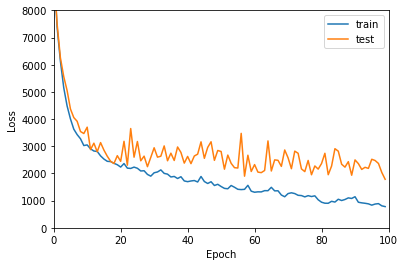

In [18]:
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.ylim(0, 8000)
plt.xlim(0, 100)
plt.legend(loc=1)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

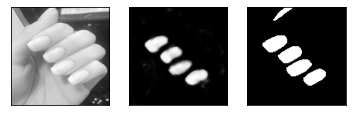

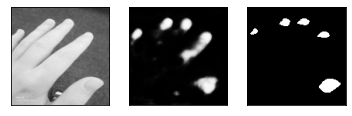

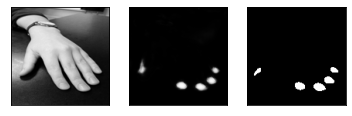

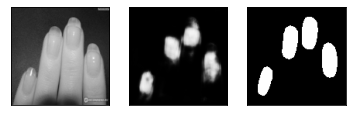

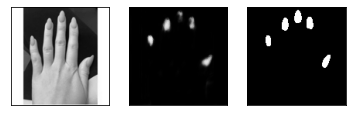

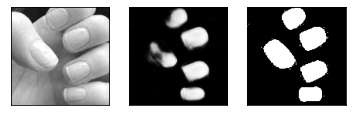

In [10]:
for x, y in test_loader:
    y_pred = net(x)
    for i in range(3):
        plt.subplot(131)
        plt.imshow(cp.asnumpy(x[i, 0]), vmax=1, vmin=0, cmap="gray")
        plt.xticks([])
        plt.yticks([])
        plt.subplot(132)
        plt.imshow(cp.asnumpy(y_pred.data[i, 0]), vmax=1, vmin=0, cmap="gray")
        plt.xticks([])
        plt.yticks([])
        plt.subplot(133)
        plt.imshow(cp.asnumpy(y[i, 0]), vmax=1, vmin=0, cmap="gray")
        plt.xticks([])
        plt.yticks([])
        plt.show()